## Instructions {-}
Ce sujet est constitué de deux parties : la partie 1 correspond au sujet donné l'an dernier, dont la correction vous est donnée, la partie 2 constitue la partie qui sera évaluée et se place dans la continuité de la partie 1.

# Enoncé du problème (Partie 1)

L'objectif de ce projet est d'estimer la longueur de câble sous-marin nécessaire pour relier deux côtes $A$ et $B$  en utilisant des simulations conditionnelles.


Le câble reposera sur le fond marin dont la profondeur est inconnue.
Le segment $[AB]$ est discrétisé par une séquence de (N+1) points. On pose $x_0=A$ et pour $i=1,\dots,N$, $$x_i=x_0+i\Delta$$ où $$\Delta = \frac{AB}{N}$$ de telle sorte que $x_N=B$.
On note $z(x)$ la profondeur du fond marin au point $x$ de telle sorte 
qu'on pourra estimer la longueur totale de câble nécessaire par la somme 
des longueurs sur les segments de la discrétisation :

$$l=\sum_{i=1}^N\sqrt{\Delta^2+(z(x_i)-z(x_{i-1}))^2}.$$

Enfin, notons que l'on dispose d'un ensemble de $n$ observations de la 
profondeur que l'on supposera situées sur des points de discrétisation $z(x_{j_1}),\dots,z(x_{j_n})$.


On adopte un modèle probabiliste pour la profondeur. On suppose que le vecteur des 
profondeurs sur les points de discrétisation 
$\mathbf{z}=(z(x_0),\dots,z(x_N))$ est la réalisation
d'un vecteur aléatoire gaussien $\mathbf{Z}=(Z(x_0),\dots,Z(x_N))$ 
dont le vecteur d'espérance ne contient qu'une seule valeur $\mu$ 
répétée $N+1$ fois et dont la matrice de covariance $\Sigma$ a pour termes $\sigma_{ij}$
définis par $\sigma_{ij}=C(|x_i-x_j|)$ où $C$ est une
fonction décroissante, traduisant le fait que deux points 
géographiquement proches ont tendance à avoir des profondeurs plus similaires que deux points éloignés.

On supposera que la matrice de covariance ainsi 
générée est définie-positive (en fait, $C$ sera choisie parmi les fonctions qui, 
appliquées aux termes d'une matrice de distance, produisent des matrices définie-positives). 

Si on note $L$ la variable aléatoire donnant la longueur de cable nécessaire : 
$$L=\sum_{i=1}^N\sqrt{\Delta^2+(Z(x_i)-Z(x_{i-1}))^2},$$
un bon estimateur de $L$ est fourni par l'espérance conditionnelle 

$$L^\star=E[L|Z(x_{j_1})=z(x_{j_1}),\dots,Z(x_{j_n})=z(x_{j_n})].$$
                                                                              
Cependant, cette quantité est difficilement accessible par le calcul. 
On va donc avoir recours à des
simulations conditionnelles. C'est-à-dire que l'on va simuler 
un nombre $K$ de réalités (disons des réalisations du modèle 
probabiliste choisi), et sur chacune d'entre elle, 
la quantité de câble nécessaire sera évaluée. 
On disposera ainsi d'un échantillon $l_{(1)},\dots,l_{(K)}$ de 
longueures simulées. Puis on approchera l'espérance conditionnelle  par 
$$L^\star=\frac1{K}\sum_{k=1}^K l_{(k)}.$$

L'objectif de ce projet est donc d'écrire un code permettant 
d'effectuer cette simulation conditionnelle, puis de l'appliquer 
au jeu de données fourni et d'en déduire une estimation de la longueur de câble nécessaire.

## Données du problème
Conventionnellement, $A$ est l'origine, $B=500$, $N=100$.

Les données $$\begin{array}{c|r}i & z(x_i)\\
\hline
0 & 0\\
20 & -4\\
40 & -12.8\\
60 & -1\\
80 & -6.5\\
100 & 0\end{array}$$

L'espérance de chaque composante du vecteur aléatoire $\mathbf{Z}$ est donnée par $\mu=-5.$

La fonction $C$ est définie par $$C(h)=\sigma^2 e^{-|h|/a},$$

où $|h|$ correspond à la distance entre deux points, $a=50$ et $\sigma^2=12$.


# Enoncé 2021 (Partie 2)

Nous nous plaçons dans le même cadre que ci-dessus. Nous tenons pour acquis les résultats précédents et allons maintenant approfondir l'analyse.

In [19]:
#les fonctions de l'année 2020 sont supposés déjà éxécutées à partir d'ici
#les revoici

import numpy as np
import matplotlib.pyplot as plt

#Discrétisation
A=0
B=500
N=101 #Nombre de points de discrétisation
Delta = (B-A)/(N-1)
discretization_indexes = np.arange(N)
discretization = discretization_indexes*Delta
#Paramètres du modèle

mu=-5
a = 50
sigma2 = 12

#Données

observation_indexes = [0,20,40,60,80,100]
depth = np.array([0,-4,-12.8,-1,-6.5,0])

#Indices des composantes correspondant aux observations et aux componsantes non observées

unknown_indexes=list(set(discretization_indexes)-set(observation_indexes))

#Fonction C

def Covexp(dist,rangeval,sigmaval):
    return sigmaval * np.exp(-dist/rangeval)

distmat=abs(np.subtract.outer(discretization,discretization))

Sigma=Covexp(distmat,a,sigma2)

SigmaObs = Sigma[observation_indexes,:][:,observation_indexes]
SigmaObsUnknown = Sigma[observation_indexes,:][:,unknown_indexes]
SigmaUnknown = Sigma[unknown_indexes,:][:,unknown_indexes]

invSigma = np.linalg.inv(SigmaObs) 
Ec= mu+np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),depth-mu))

allval1 = np.zeros(N)
allval1[unknown_indexes]=Ec
allval1[observation_indexes]=depth

SigmaCond = SigmaUnknown - np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),SigmaObsUnknown))

allval2 = np.zeros(N)
allval2[unknown_indexes]=np.diag(SigmaCond)

Cholesky = np.linalg.cholesky(SigmaCond)
x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
simu = Ec + np.matmul(Cholesky,x)

allval3 = np.zeros(N)
allval3[unknown_indexes]=simu
allval3[observation_indexes]=depth

def length(z,delta):
    return sum(np.sqrt(delta**2+(z[1:N]-z[0:-1])**2))

K=10000
result = np.zeros(K)
for i in range(K):
    x=np.random.normal(0,1,np.shape(unknown_indexes)[0])
    allval3[unknown_indexes]=Ec + np.matmul(Cholesky,x)
    result[i]=length(allval3,Delta)
    
indice_simu = 1+np.arange(K)

Ln = sum(result)/K
sigman = np.std(result)

## Valeurs positives

1. A la question 7 de la partie 1, on peut s'apercevoir que certains profils de profondeur présentent des valeurs positives, ce qui n'a pas de sens si on considère qu'il n'y a pas de partie émergée entre les deux côtes. Proposer et implémenter un algorithme de type rejet qui ne génèrera que des valeurs négatives. Représenter un profil de profondeur généré.

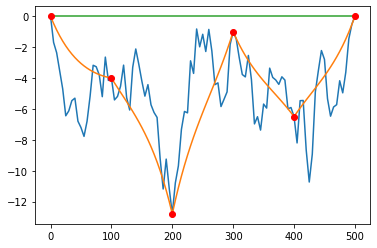

In [20]:
sol=np.zeros(len(discretization))
x_rejet = np.random.normal(0,1,np.shape(unknown_indexes)[0])
simu_rejet = Ec + np.matmul(Cholesky,x_rejet)
allval3_rejet = np.zeros(N)
allval3_rejet[unknown_indexes]=simu_rejet
def test(rejet,sim):
    N=len(rejet)
    for i in range(N):
        if rejet[i]<sim[i]:
            return False
    return True

while not test(sol,allval3_rejet):
    x_rejet = np.random.normal(0,1,np.shape(unknown_indexes)[0])
    simu_rejet = Ec + np.matmul(Cholesky,x_rejet)
    allval3_rejet = np.zeros(N)
    allval3_rejet[unknown_indexes]=simu_rejet
    
allval3_rejet[observation_indexes]=depth
plt.plot(discretization,allval3_rejet)
plt.plot(discretization,allval1)
plt.plot(discretization,sol)
plt.plot(discretization[observation_indexes], depth, 'ro')
plt.show()



2. L'emploi de cet algorithme a-t-il un impact sur la valeur moyenne de la longueur de câble ? Sur l'histogramme des longueurs de câble ? Sur l'intervalle de confiance obtenu par la méthode des quantiles ? Sur la probabilité de dépassement du seuil de 525 m? Donner une estimation du taux de rejet de l'algorithme. Considérer 10000 simulations.

In [22]:
K=10000
#calcul du taux de rejet
nbrExecution=0
result_rejet=np.zeros(K)
for i in range(K):
    x_rejet = np.random.normal(0,1,np.shape(unknown_indexes)[0])
    simu_rejet = Ec + np.matmul(Cholesky,x_rejet)
    allval3_rejet = np.zeros(N)
    allval3_rejet[unknown_indexes]=simu_rejet
    nbrExecution+=1
    
    while not test(sol,allval3_rejet):
        x_rejet = np.random.normal(0,1,np.shape(unknown_indexes)[0])
        simu_rejet = Ec + np.matmul(Cholesky,x_rejet)
        allval3_rejet = np.zeros(N)
        allval3_rejet[unknown_indexes]=simu_rejet
        nbrExecution+=1
    
    allval3_rejet[observation_indexes]=depth
    result_rejet[i]=length(allval3_rejet,Delta)
((nbrExecution-K)/nbrExecution)*100

96.20907698606457

In [23]:
#ancienne valeur moyenne, calculée par simulation  conditionnelle sans rejet
sum(result)/K

522.4101376313853

In [24]:
#nouvelle valeur moyenne, calculée par simulation conditionnelle avec rejet
sum(result_rejet)/K

521.7923965197785

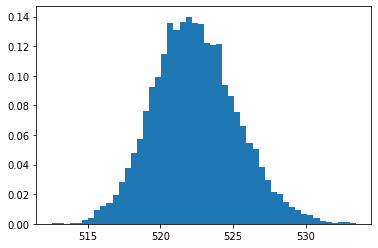

In [25]:
#tracé de l'histogramme sans rejet
plt.hist(result,50,density=True)
plt.show()

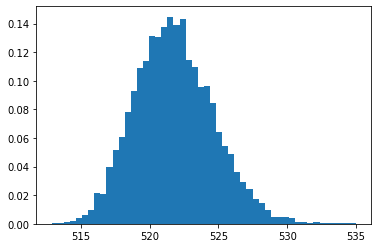

In [26]:
#tracé de l'histogramme avec rejet
plt.hist(result_rejet,50,density=True)
plt.show()

In [27]:
#intervalle de confiance sans rejet
np.quantile(result,[0.025,0.975])

array([517.06448858, 528.41841307])

In [28]:
#intervalle de confiance avec rejet
np.quantile(result_rejet,[0.025,0.975])

array([516.67479893, 527.76204508])

In [29]:
#probabilité de dépassement du seuil de 525m sans rejet
np.mean(result>525)

0.1824

In [30]:
#probabilité de dépassement du seuil de 525m avec rejet
np.mean(result_rejet>525)

0.1316

## Approche Bayésienne

Dans la première partie, on a considéré que l'ensemble des paramètres du modèle était parfaitement connu. Toutes choses égales par ailleurs, on va maintenant considérer que la moyenne $\mu$ est issue d'une estimation entâchée d'une incertitude. Plus précisément, on va modéliser cette incertitude en considérant que $\mu \sim \mathcal{N}(-5,4)$.

On va également décomposer le vecteur $\mathbf{Z}$ en $\mathbf{Z} = (\mathbf{Z}_{\text{OBS}},\mathbf{Z}_{\text{UNK}})$. On notera $C_{\text{OBS}}$ et $C_{\text{UNK}}$ les matrices de covariance respectives de $\mathbf{Z}_{\text{OBS}}$ et $\mathbf{Z}_{\text{UNK}}$ ainsi que $C_{\text{OBS},\text{UNK}}$ la matrice des covariances entre ces deux vecteurs.

### Questions théoriques

3. Montrer que $\mu | \mathbf{Z}_{\text{OBS}}= \mathbf{z}_{\text{OBS}} \sim \mathcal{N}(\widehat{\mu},\widehat{\sigma}^2)$ avec
$$\widehat{\sigma}^2 = (\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{1} + \frac1{4})^{-1},$$ 
où $\mathbf{1}$ est un vecteur de longueur 6 (soit la longueur du vecteur $\mathbf{Z}_{\text{OBS}}$) ne contenant que des 1 et 
$$\widehat{\mu} = \widehat{\sigma}^2 (\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{z}_{\text{OBS}} - \frac{5}{4} )$$
Indication : écrire la densité jointe du vecteur $(\mathbf{Z}_{\text{OBS}},\mu)$, calculer $-2 \ln$ de cette densité puis identifier la forme quadratique faisant intervenir $\mu$.

Ecrivons la densité jointe du vecteur $(\mathbf{Z}_{\text{OBS}},\mu)$ <br> $f_{\mathbf{Z}_{\text{OBS}},\mu}(z_\text{OBS},\mu^\star)=f_\mu(\mu^\star)f_{\mathbf{Z}_{\text{OBS}}|{\mu=\mu^\star}}(z_\text{OBS})$ <br> On sait que $\mu$ suite une loi normale, donc $f_\mu(\mu^\star)$ est connu et vaut: <br> $f_\mu(\mu^\star)={{1}\over{2\sqrt{2\pi}}}\exp{-\frac{(5+\mu^\star)^2}{8}}$<br> Et,$\mathbf{Z}_{\text{OBS}}$ est un vecteur gaussien de taille, la longueur d'observation_indexes,soit $6$. D'où,<br> $f_{\mathbf{Z}_{\text{OBS}}|{\mu=\mu^\star}}(z_\text{OBS})= {{1}\over{(2\pi)^3\sqrt{det(\mathbf{C}_{\text{OBS}})}}}\exp({{-1}\over{2}}(z_{\text{OBS}}-\mu{^\star}\mathbf{1})^t C_{\text{OBS}}^{-1} ({z}_{\text{OBS}}-\mu{^\star}\mathbf{1}) $ <br>
On a donc $f_{\mathbf{Z}_{\text{OBS}},\mu}(z_\text{OBS},\mu^\star)={{1}\over{2\sqrt{2\pi}}}\exp{-\frac{(5+\mu^\star)^2}{8}}{{1}\over{(2\pi)^3\sqrt{det(\mathbf{C}_{\text{OBS}})}}}\exp({{-1}\over{2}}(z_{\text{OBS}}-\mu{^\star}\mathbf{1})^t C_{\text{OBS}}^{-1} ({z}_{\text{OBS}}-\mu{^\star}\mathbf{1})$

Et, $f_{\mathbf{Z}_{\text{OBS}},\mu}(z_\text{OBS},\mu^\star)=f_{\mathbf{Z}_{\text{OBS}}}(z_\text{OBS})f_{\mu|\mathbf{Z}_{\text{OBS}}=z_\text{OBS}}(\mu^\star)$ <br> D'où, <br> $-2\ln(f_{\mathbf{Z}_{\text{OBS}}}(z_\text{OBS})f_{\mu|\mathbf{Z}_{\text{OBS}}=z_\text{OBS}}(\mu^\star))=-2\ln({{1}\over{2\sqrt{2\pi}}}\exp{-\frac{(5+\mu^\star)^2}{8}}{{1}\over{(2\pi)^3\sqrt{det(\mathbf{C}_{\text{OBS}})}}}\exp({{-1}\over{2}}(z_{\text{OBS}}-\mu{^\star}\mathbf{1})^t C_{\text{OBS}}^{-1} ({z}_{\text{OBS}}-\mu{^\star}\mathbf{1}))$

$-2\ln(f_{\mathbf{Z}_{\text{OBS}}}(z_\text{OBS})f_{\mu|\mathbf{Z}_{\text{OBS}}=z_\text{OBS}}(\mu^\star))=2\ln{2}+6\ln{2\pi}+\ln{2det(\mathbf{C}_{\text{OBS}})}+{{25}\over{4}}+{{{\mu^\star}^2}\over{4}}+{{5{\mu^\star}}\over{2}}+{z_{\text{OBS}}}^t C_{\text{OBS}}^{-1} {z}_{\text{OBS}}$$-{\mu{^\star}\mathbf{1}}^t C_{\text{OBS}}^{-1} {z}_{\text{OBS}}$$-{z_{\text{OBS}}}^t C_{\text{OBS}}^{-1}\mu{^\star}\mathbf{1}+{\mu{^\star}}^2{\mathbf{1}}^t C_{\text{OBS}}^{-1}\mathbf{1}$

On identifie les termes ne faisant pas apparaître $\mu^\star$ à $-2\ln(f_{\mathbf{Z}_{\text{OBS}}}(z_\text{OBS}))$ ainsi qu'aux autres constantes de proportionnalité apparaissant aussi dans la loi normale, et les termes restant sont identifiés à $-2\ln(f_{\mu|\mathbf{Z}_{\text{OBS}}=z_\text{OBS}}(\mu^\star)))$ pour la partie quadratique en $\mu^\star$

Soit :<br> $-2\ln(f_{\mu|\mathbf{Z}_{\text{OBS}}=z_\text{OBS}}(\mu^\star)))={{{\mu^\star}^2}\over{4}}+{{5{\mu^\star}}\over{2}}-{\mu{^\star}\mathbf{1}}^t C_{\text{OBS}}^{-1} {z}_{\text{OBS}}-{z_{\text{OBS}}}^t C_{\text{OBS}}^{-1}\mu{^\star}\mathbf{1}+{\mu{^\star}}^2{\mathbf{1}}^t C_{\text{OBS}}^{-1}\mathbf{1}+\text{constante qui ne nous intéresse pas}$

Comme ${\mu{^\star}\mathbf{1}}^t C_{\text{OBS}}^{-1} {z}_{\text{OBS}} $ est réel, il est égal à sa transposée et car la matrice de covariance est symétrique, d'où ${\mu{^\star}\mathbf{1}}^t C_{\text{OBS}}^{-1} {z}_{\text{OBS}}={z_{\text{OBS}}}^t C_{\text{OBS}}^{-1}\mu{^\star}\mathbf{1}$

$-2\ln(f_{\mu|\mathbf{Z}_{\text{OBS}}=z_\text{OBS}}(\mu^\star)))={{{\mu^\star}^2}\over{4}}+{{5{\mu^\star}}\over{2}}-2{\mu{^\star}\mathbf{1}}^t C_{\text{OBS}}^{-1} {z}_{\text{OBS}}+{\mu{^\star}}^2{\mathbf{1}}^t C_{\text{OBS}}^{-1}\mathbf{1}+\text{constante qui ne nous intéresse pas}$

On rappelle, qu'une loi normale $\mathcal{N}(\widehat{\mu},\widehat{\sigma}^2)$ aurait comme densité $f$ telle que: <br> $-2\ln(f(\mu^\star))=2\ln(\sqrt{2\pi}{\widehat{\sigma}})+{{(\mu^\star-\widehat{\mu})^2}\over{2{\widehat{\sigma}}^2}}$<br>$-2\ln(f(\mu^\star))=\ln({2\pi}{\widehat{\sigma}^2})+{{(\mu^\star-\widehat{\mu})^2}\over{2{\widehat{\sigma}}^2}}$<br>$-2\ln(f(\mu^\star))=\ln({2\pi}(\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{1} + \frac1{4})^{-1})+{{(\mu^\star-\widehat{\mu})^2}\over{2{\widehat{\sigma}}^2}}$<br>$-2\ln(f(\mu^\star))=\ln({2\pi}(\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{1} + \frac1{4})^{-1})+{{(\mu^\star-\widehat{\sigma}^2 (\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{z}_{\text{OBS}} - \frac{5}{4} ))^2}\over{2{\widehat{\sigma}}^2}}$<br>$-2\ln(f(\mu^\star))=\ln({2\pi}(\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{1} + \frac1{4})^{-1})+{{(\mu^\star-{(\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{1} + \frac1{4})^{-1}} (\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{z}_{\text{OBS}} - \frac{5}{4} ))^2}\over{2(\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{1} + \frac1{4})^{-1}}}$ 

On ne s'intéresse encore une fois qu'à la partie quadratique en $\mu^\star$.<br> Soit $-2\ln(f(\mu^\star))={{{\mu^\star}^2}\over{2}}(\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{1} + \frac1{4})+\mu^\star(\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{z}_{\text{OBS}} - \frac{5}{4} )+\text{autre constante qui ne nous intéresse pas}$

On peut alors identifier $f_{\mu | \mathbf{Z}_{\text{OBS}}= \mathbf{z}_{\text{OBS}}} $ à une loi normale de paramètres $(\widehat{\mu},\widehat{\sigma}^2)$.

4. Montrer que si $X$, $Y$ et $Z$ sont trois vecteurs aléatoires à densité, alors $f_{X,Y|Z = z}(x,y) = f_{X|Y=y,Z=z}(x)f_{Y|Z=Z}(y)$

Soit $V=(X,Y)$.<br>Alors $f_{V,Z}(x,y,z)=f_{V|Z=z}(x,y)f_{Z}(z)=f_{X|Y=y,Z=z}(x)f_{Y|Z=z}(y)f_{Z}(z)$
        Ceci est vrai pour tout $z$, si $z=0$, le résultat est trivial, sinon on simplifie par $f_{Z}(z)$. D'où le résultat, $f_{X,Y|Z = z}(x,y) = f_{X|Y=y,Z=z}(x)f_{Y|Z=Z}(y)$.

5. En déduire que la densité de $(\mathbf{Z}_{\text{UNK}},\mu) | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$ s'écrit comme le produit de $f_{\mu | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ et de $f_{\mathbf{Z}_{\text{UNK}}| \mu = \mu^\star, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ que l'on exprimera.

    Indication : $f_{\mathbf{Z}_{\text{UNK}}| \mu = \mu^\star, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ est identique à la densité $f_{\mathbf{Z}_{\text{UNK}}| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ utilisée dans la partie 1 avec $\mu = \mu^\star$

On applique le résultat de la question $4$ avec $X=\mathbf{Z}_{\text{UNK}}$, $Y=\mu$ et $Z=\mathbf{Z}_{\text{OBS}}$ <br> Alors, $f_{\mathbf{Z}_{\text{UNK}},\mu|\mathbf{Z}_{\text{OBS}} =\mathbf{z}_{\text{OBS}}}(\mathbf{z}_{\text{UNK}},\mu^\star) = f_{\mathbf{Z}_{\text{UNK}}| \mu = \mu^\star}\mathbf{Z}_{\text{OBS}}(\mathbf{z}_{\text{UNK}})f_{\mu|\mathbf{Z}_{\text{OBS}} =\mathbf{z}_{\text{OBS}}}(\mu^\star)$ <br> Explicitons ce résultat.<br>$f_{\mu|\mathbf{Z}_{\text{OBS}} =\mathbf{z}_{\text{OBS}}}(\mu^\star)$ suit une gaussienne comme dit précédemment. Et, $f_{\mathbf{Z}_{\text{UNK}}| \mu = \mu^\star}\mathbf{Z}_{\text{OBS}}(\mathbf{z}_{\text{UNK}})$ suit la loi que l'on retrouve page $18$ de probabilités III avec $\mu^\star$ au lieu de $\mu$.<br> Soit, $$f_{\mathbf{Z}_{\text{UNK}}| \mu = \mu^\star}\mathbf{Z}_{\text{OBS}}(\mathbf{z}_{\text{UNK}})={{1}\over{(2\pi)^{(N+1-6)/2}\sqrt{det(C_\text{UNK}-C_{\text{OBS},\text{UNK}}C_\text{OBS}^{-1}C_{\text{OBS},\text{UNK}}})}}\exp(-{{1}\over{2}}({z_\text{UNK}-\mu^\star+C_{\text{OBS},\text{UNK}}C_\text{OBS}^{-1}(z_\text{UNK}-\mu^\star)}^t+{C_\text{UNK}-C_{\text{OBS},\text{UNK}}C_\text{OBS}^{-1}C_{\text{OBS},\text{UNK}}}^{-1}z_\text{UNK}-\mu^\star+C_{\text{OBS},\text{UNK}}C_\text{OBS}^{-1}(z_\text{UNK}-\mu^\star))$$


### Simulation

On va maintenant chercher à simuler les valeurs de $\mathbf{Z}_{\text{UNK}}$ en tenant compte de l'incertitude sur $\mu$.

En première approche, on pourrait chercher à obtenir la densité de $\mathbf{Z}_{\text{UNK}} | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$ en calculant 
$$\int_\mathbb{R} f_{(\mathbf{Z}_{\text{UNK}},\mu) | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}(\mathbf{z}_{\text{UNK}},\mu^\star) d\mu^\star$$
mais ce calcul a peu de chances d'aboutir.

On va plutôt procéder par simulations en cascade, c'est-à-dire que pour chaque simulation de $\mathbf{Z}_{\text{UNK}}$, on va d'abord générer une valeur $\mu^\star$ de $\mu$ selon $f_{\mu | \mathbf{Z}_{\text{OBS}}= \mathbf{z}_{\text{OBS}}}$ puis on simulera $\mathbf{Z}_{\text{UNK}}$ selon $f_{\mathbf{Z}_{\text{UNK}}| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}},\mu = \mu^\star}$.


6. Calculer $\widehat{\mu}$ et $\widehat{\sigma}^2$. 

In [15]:
sigma_carre_chapeau= 1/(np.matmul(np.matmul(np.ones(6).transpose(), np.linalg.inv(SigmaObs)),np.ones(6))+1/4)
mu_chapeau = sigma_carre_chapeau*(np.matmul(np.matmul(np.ones(6).transpose(), np.linalg.inv(SigmaObs)), depth)-5/4)
mu_chapeau,sigma_carre_chapeau

(-4.291350330933772, 1.5368909974762894)

7. Calculer la probabilité de $\{\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}} > 0\}$. Proposer et implémenter un algorithme de simulation de $\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}, \mu <0$.

On rappelle que $\mu | \mathbf{Z}_{\text{OBS}}= \mathbf{z}_{\text{OBS}} \sim \mathcal{N}(\widehat{\mu},\widehat{\sigma}^2)$. Comme on ne connaît pas aisément la fonction de répartition d'une loi normale, on va calculer à l'aide d'un algorithme de simulation la probabilité demandée.

In [20]:
def loi_normale(x):
    return np.exp(-(x-mu_chapeau)**2/(2*sigma_carre_chapeau)) / (np.sqrt(2*np.pi*sigma_carre_chapeau))


In [21]:
from scipy.integrate import quad 

In [23]:
quad(loi_normale,0,np.inf)[0]

0.0002685226388166117

In [24]:
def simu_loi_normale_negative():
    negatif = False
    while not negatif:
        valeur = np.random.normal(mu_chapeau,sigma_carre_chapeau)
        if valeur < 0:
            negatif=True
    return valeur
        

On constate qu'il est très improbable que la variable aléatoire soit positive.

8. Générer un couple $\mathbf{Z}_{\text{UNK}}, \mu| \mathbf{Z}_{\text{OBS}}, \mu <0$ et représenter le profil de profondeur obtenu. On prendra soin de ne générer que des valeurs négatives de $\mathbf{Z}_{\text{UNK}}$ en utilisant l'algorithme de la section précédente.

Comme vu à la question 5, on sait que 

9. Générer 10000 profils de profondeur et calculer les longueurs de câble associées. Comparer la valeur moyenne de la longueur de câble, dont on visualisera la convergence, l'histogramme des longueurs de câble, l'intervalle de confiance obtenu par la méthode des quantiles, la probabilité de dépassement du seuil de 525 m avec les résultats obtenus précédemment. Commenter.

10. Qu'adviendrait-il selon vous si on rendait également aléatoires les autres paramètres du modèle $\sigma^2$ et $a$ ?

11. (facultatif) On suppose désormais que $\alpha = \frac1{\sigma^2} \sim \Gamma(a_1,a_2)$, où $\sigma^2$ correspond au paramètre qui intervient dans la fonction $C$. Donner l'expression de la densité de $\alpha | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$,  de $\mu | \alpha, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}},$ et de $\mathbf{Z}_{\text{UNK}} | \mu, \alpha, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$. Proposer un algorithme de simulation tenant compte de l'incertitude sur le paramètre $\alpha$ et analyser son impact sur les différentes quantités évaluées.

    Indication : Pour identifier la densité de $\alpha | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$, exprimer d'abord la densité jointe de $(\alpha,\mu, \mathbf{Z}_{\text{OBS}})$ puis marginaliser pour obtenir la densité de $(\alpha,\mathbf{Z}_{\text{OBS}})$
